# Supplementary Figure S2 - World Recipe Matrix

Post hoc enrichment-based annotation of a non-biological, hierarchically clustered world-wide recipe matrix using ingredient similarity and country-of-origin annotations.

In [1]:
# Enable inline plotting for notebooks
%matplotlib inline

In [2]:
# Figure export utilities (PNG, 300 DPI).
import re
from pathlib import Path

import matplotlib.pyplot as plt

PNG_DIR = Path("png") / "supp_fig_2"
PNG_DIR.mkdir(parents=True, exist_ok=True)


def _to_snake_case(name):
    text = re.sub(r"[^0-9a-zA-Z]+", "_", name.strip().lower())
    return re.sub(r"_+", "_", text).strip("_")


def save_figure_png(name, *, fig=None, dpi=300, pad_inches=0.02):
    """Save a Matplotlib figure as a high-quality PNG in the notebook export folder."""
    if fig is None:
        fig = plt.gcf()
    output_path = PNG_DIR / f"{_to_snake_case(name)}.png"
    fig.savefig(
        output_path,
        dpi=dpi,
        bbox_inches="tight",
        pad_inches=pad_inches,
        facecolor=fig.get_facecolor(),
        edgecolor="none",
    )
    print(f"Saved {output_path}")
    return output_path

## Load Inputs

Load and clean recipe ingredient text, then merge near-duplicate ingredient tokens.

In [3]:
from difflib import SequenceMatcher

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

DATA_PATH = "data/interdisciplinary/WorldWideDishes_2024_June.xlsx"
MIN_RECIPES_PER_INGREDIENT = 3
MIN_INGREDIENTS_PER_RECIPE = 3

# Load and validate recipe table.
df = pd.read_excel(DATA_PATH)
df = df.set_index("id", drop=True)

# Filter generic non-informative tokens.
BAD_TOKENS = {
    "etc",
    "and or others",
    "or spinach leaves",
    "knorr etc",
    "the bark of lep",
}

BAD_PHRASE_RE = re.compile(
    r"\b(" r"etc|and or|or .*|of choice|as needed|optional|" r"your |made from|mixed with" r")\b"
)


def clean_ingredient(token):
    """Normalize one ingredient token to lowercase alphanumeric text."""
    if not isinstance(token, str):
        return ""
    token = token.lower()
    token = re.sub(r"\([^)]*\)", "", token)
    token = re.sub(r"[\"'“”‘’]", "", token)
    token = re.sub(r"[^a-z0-9\s]", " ", token)
    return re.sub(r"\s+", " ", token).strip()


def parse_and_clean_ingredients(s):
    """Split one ingredient field and return cleaned tokens."""
    if not isinstance(s, str):
        return []
    toks = []
    for raw in s.split(","):
        tok = clean_ingredient(raw)
        if not tok:
            continue
        if tok in BAD_TOKENS:
            continue
        if BAD_PHRASE_RE.search(tok):
            continue
        toks.append(tok)
    return toks


def is_near_spelling_variant(a, b):
    """Return True when two tokens are likely spelling variants."""
    return SequenceMatcher(None, a, b).ratio() >= 0.90


# Parse cleaned ingredient lists and build raw vocabulary.
df["ingredients_clean"] = df["ingredients"].apply(parse_and_clean_ingredients)
ingredient_lists = df["ingredients_clean"]
all_ingredients = sorted({ing for lst in ingredient_lists for ing in lst})

In [4]:
from collections import defaultdict

# Explicit spelling fixes for variants.
EXPLICIT_RENAMES = {
    "balck pepper": "black pepper",
    "bananaleaf": "banana leaf",
    "carrots": "carrot",
    "casava": "cassava",
    "chickpeas": "chickpea",
    "chilli": "chili",
    "chilli pepper": "chili pepper",
    "cinamon": "cinnamon",
    "cloves": "clove",
    "curry poweder": "curry powder",
    "dryred chilli": "dry red chili",
    "garli": "garlic",
    "giner": "ginger",
    "green chilli": "green chili",
    "ground cardamon": "ground cardamom",
    "onions": "onion",
    "red chiili": "red chili",
    "red chilli powder": "red chili powder",
    "shallots": "shallot",
    "tumeric": "turmeric",
    "tumeric powder": "turmeric powder",
    "yoghurt": "yogurt",
}

ingredient_rename_map = {}
merged_ingredients = []
for ing in all_ingredients:
    if ing in EXPLICIT_RENAMES:
        merged = EXPLICIT_RENAMES[ing]
        ingredient_rename_map[ing] = merged
        if merged not in merged_ingredients:
            merged_ingredients.append(merged)
        continue

    for merged in merged_ingredients:
        if is_near_spelling_variant(ing, merged):
            ingredient_rename_map[ing] = merged
            break
    else:
        ingredient_rename_map[ing] = ing
        merged_ingredients.append(ing)

# Preview grouped spelling variants for transparency.
grouped = defaultdict(list)
for ing, merged in ingredient_rename_map.items():
    if ing != merged:
        grouped[merged].append(ing)
if grouped:
    print("Grouped spelling variants:")
    for merged, vars_ in sorted(grouped.items()):
        print(f"  {merged} <- {', '.join(sorted(vars_))}")

ingredients = merged_ingredients
print(f"Final ingredient vocabulary: {len(ingredients)}")

Grouped spelling variants:
  banana leaf <- bananaleaf
  beef stripes <- beef tripe
  black bean <- black beans
  black eyed pea <- black eyed peas
  black pepper <- balck pepper
  carrot <- carrots
  cassava <- casava
  chickpea <- chickpeas
  chili <- chilli
  chili pepper <- chilli pepper
  cinnamon <- cinamon
  clove <- cloves
  coariander leaves <- corainder leaves, coriander leaves
  coriander powder <- corianer powder
  curry powder <- curry poweder
  dried shrimp <- fried shrimp
  dry red chili <- dryred chilli
  eggplant <- eggplants
  garlic <- garli
  ginger <- giner
  ginger paste <- gingerpaste
  green chili <- green chilli
  green pepper <- green peppers
  ground cardamom <- ground cardamon
  heavey cocnut milk <- heavy coconut milk
  kechup <- ketchup
  kidney <- kidneys
  onion <- onions
  ox tail <- oxtail
  papaya <- pappaya
  peanut <- peanuts
  pepper <- peppers
  plantain <- plantains
  red chili <- red chiili, red chilli
  red chili powder <- red chilli powder
  r

## Build Matrix and Annotation Mapping

Build the recipe-by-ingredient matrix and country-to-recipe annotation mapping.

In [5]:
# Build sparse recipe-by-ingredient matrix.
ingredient_to_col = {ing: i for i, ing in enumerate(ingredients)}
row_idx = []
col_idx = []
data = []
for i, ing_list in enumerate(ingredient_lists):
    seen = set()
    for ing in ing_list:
        merged = ingredient_rename_map.get(ing, ing)
        if merged in seen:
            continue
        seen.add(merged)
        row_idx.append(i)
        col_idx.append(ingredient_to_col[merged])
        data.append(1)

X = csr_matrix(
    (data, (row_idx, col_idx)),
    shape=(len(df), len(ingredients)),
    dtype=np.uint8,
)

ingredient_matrix = pd.DataFrame.sparse.from_spmatrix(
    X,
    index=df.index,
    columns=ingredients,
)

# Frequency-based filtering.
ingredient_support = ingredient_matrix.sum(axis=0)
cols_keep = ingredient_support[ingredient_support >= MIN_RECIPES_PER_INGREDIENT].index
ingredient_matrix = ingredient_matrix.loc[:, cols_keep]

row_keep = ingredient_matrix.sum(axis=1) >= MIN_INGREDIENTS_PER_RECIPE
ingredient_matrix = ingredient_matrix.loc[row_keep]

print(f"Ingredient matrix shape: {ingredient_matrix.shape} | kept {len(cols_keep)} ingredients")

Ingredient matrix shape: (537, 238) | kept 238 ingredients


In [6]:
def parse_countries(s):
    """Split one country field into normalized country tokens."""
    if not isinstance(s, str):
        return []
    return [tok.strip().lower() for tok in s.split(",") if tok.strip()]


country_to_recipes = defaultdict(set)
for recipe_id, country_str in df["countries"].items():
    for country in parse_countries(country_str):
        country_to_recipes[country.title()].add(recipe_id)

country_to_recipes = {country: sorted(ids) for country, ids in country_to_recipes.items()}
print(f"Number of countries: {len(country_to_recipes)}")

Number of countries: 106


## Cluster, Enrich, and Filter

Run hierarchical clustering, test enrichment across dendrogram-defined clusters and categorical annotations, and filter by Benjamini-Hochberg FDR (`qval <= 0.05`).

In [7]:
from himalayas import Matrix, Annotations, Analysis

LINKAGE_THRESHOLD = 8.5

# Build core objects.
matrix = Matrix(ingredient_matrix)
annotations = Annotations(
    country_to_recipes,
    matrix,
)
# Run clustering + enrichment.
analysis = (
    Analysis(matrix, annotations)
    .cluster(
        linkage_method="ward",
        linkage_metric="euclidean",
        linkage_threshold=LINKAGE_THRESHOLD,
        min_cluster_size=18,
    )
    .enrich(min_overlap=2)
    .finalize(
        col_cluster=True,
        add_qvalues=True,
    )
)
results = analysis.results
results_sig = results.filter("qval <= 0.05")

# Optional: explicit cluster-level label table for inspection/export.
cluster_labels = results_sig.cluster_labels(
    term_col="term",
    cluster_col="cluster",
    weight_col="pval",
    label_mode="top_term",
    label_col="term",
)
cluster_labels["label"] = cluster_labels["label"].str.title()

print(f"All enriched rows: {len(results.df):,}")
print(f"Significant rows (q<=0.05): {len(results_sig.df):,}")
print(results_sig.df.head(10))
print("\nCluster-level labels:")
print(cluster_labels)

All enriched rows: 91
Significant rows (q<=0.05): 18
   cluster                              term   k   K    n    N          pval  \
0        3                             India  22  55   22  537  1.972080e-24   
1        4                           Nigeria  25  58   40  537  4.090781e-17   
2        6                             Japan  17  18   87  537  1.390607e-13   
3        7  Democratic Republic Of The Congo  14  17  121  537  1.699435e-07   
4        7                           Algeria  36  80  121  537  9.162448e-07   
5        8                       Philippines  13  26   78  537  1.079136e-05   
6        1                           Algeria  15  80   39  537  1.451353e-04   
7        5                             Kenya  17  65   61  537  2.826877e-04   
8        1                           Morocco   4   6   39  537  3.232633e-04   
9        1                       Netherlands   3   3   39  537  3.560878e-04   

           qval  
0  1.794593e-22  
1  1.861305e-15  
2  4.218175e

/Users/irahorecka/Desktop/harddrive_desktop/PhD/University of Toronto/Rost Lab/GitHub/himalayas/src/himalayas/core/annotations.py:72: RuntimeWarning: Dropped 13/106 annotations with no overlap to matrix labels
  warn(


## Render Annotated Matrix

Render matrix, dendrogram, cluster-level labels, and the enrichment significance track.

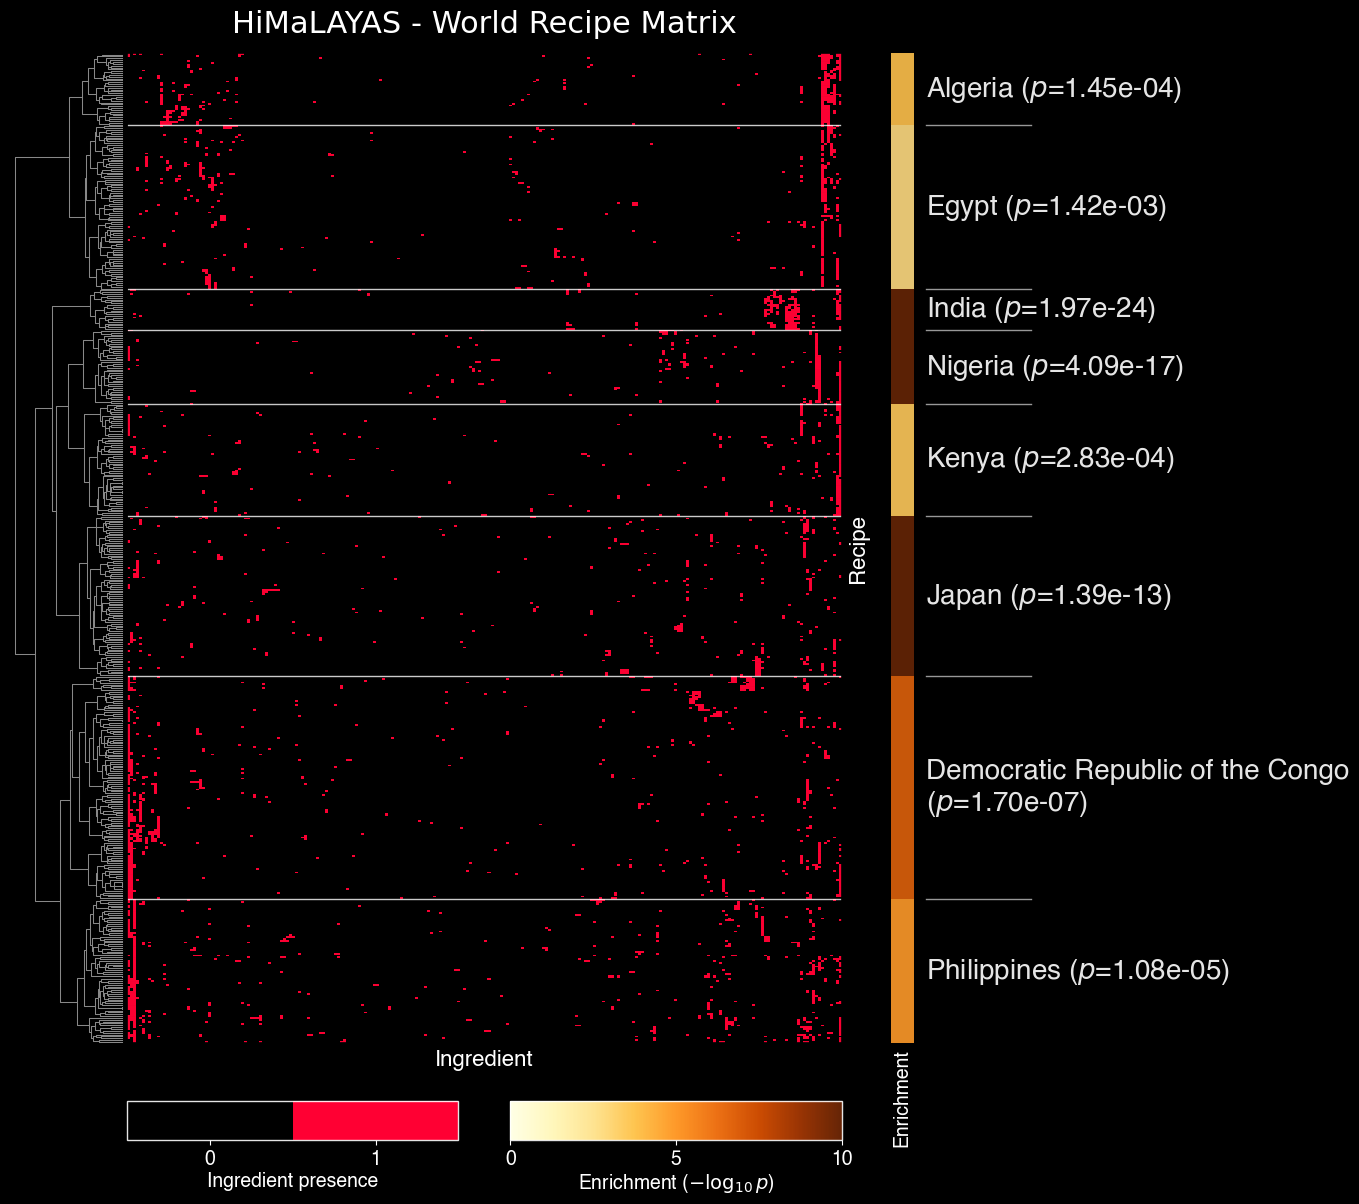

In [8]:
from matplotlib.colors import BoundaryNorm, ListedColormap, Normalize
from himalayas.plot import Plotter

LABEL_COLOR = "white"
BACKGROUND_COLOR = "black"
FONT = "Helvetica"


# Build a discrete two-level palette for ingredient absence/presence.
def make_discrete_palette(absent="#000000", present="#FF0033", name="IngredientPresence"):
    """Build a two-level colormap and norm for ingredient absence/presence."""
    cmap = ListedColormap([absent, present], name=name)
    norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=cmap.N)
    return cmap, norm


matrix_cmap, matrix_norm = make_discrete_palette(
    absent="#000000",
    present="#FF0033",
)
enrichment_norm = Normalize(0, 10)

plotter = (
    Plotter(results_sig)
    .set_background(color=BACKGROUND_COLOR)
    .plot_title(
        "HiMaLAYAS - World Recipe Matrix",
        color=LABEL_COLOR,
        font=FONT,
        fontsize=22,
    )
    .plot_dendrogram(
        axes=[0.06, 0.05, 0.09, 0.90],
        data_pad=0.75,
        color="#888888",
        linewidth=0.75,
    )
    .plot_matrix(
        cmap=matrix_cmap,
        vmin=0,
        vmax=1,
        figsize=(13, 11),
        subplots_adjust={
            "left": 0.15,
            "right": 0.70,
            "bottom": 0.05,
            "top": 0.95,
        },
    )
    .plot_matrix_axis_labels(
        xlabel="Ingredient",
        ylabel="Recipe",
        font=FONT,
        fontsize=16,
        color=LABEL_COLOR,
        xlabel_pad=4.5,
        ylabel_pad=0.005,
    )
    .plot_cluster_labels(
        term_col="term",
        cluster_col="cluster",
        weight_col="pval",
        label_mode="top_term",
        label_col="term",
        max_words=24,
        wrap_text=True,
        wrap_width=40,
        overflow="wrap",
        font=FONT,
        fontsize=20,
        color=LABEL_COLOR,
        skip_unlabeled=False,
        label_fields=("label", "p"),
        omit_words=(),
        boundary_color=LABEL_COLOR,
        boundary_lw=1,
        boundary_alpha=0.8,
        dendro_boundary_alpha=0.0,
        label_text_pad=0.012,
        label_sep_xmin=None,
        label_sep_xmax=0.5,
        label_sep_color=LABEL_COLOR,
        label_sep_lw=1.0,
        label_sep_alpha=0.6,
        label_gutter_color=BACKGROUND_COLOR,
        overrides={7: "Democratic Republic of the Congo"},
        axes=[0.70, 0.05, 0.29, 0.90],
    )
    .plot_cluster_bar(
        norm=enrichment_norm,
        name="sigbar",
        title="Enrichment",
        width=0.06,
        left_pad=0.1,
        right_pad=0.02,
    )
    .plot_bar_labels(
        font=FONT,
        fontsize=14,
        color=LABEL_COLOR,
        pad=4,
        rotation=90,
    )
    .set_label_track_order(("sigbar",))
    .add_colorbar(
        name="matrix",
        cmap=matrix_cmap,
        norm=matrix_norm,
        label="Ingredient presence",
        ticks=[0, 1],
    )
    .add_colorbar(
        name="enrichment",
        cmap="YlOrBr",
        norm=enrichment_norm,
        label=r"Enrichment ($-\log_{10}p$)",
        ticks=[0, 5, 10],
    )
    .plot_colorbars(
        ncols=2,
        height=0.035,
        gap=0.0525,
        hpad=0.04,
        vpad=0.00,
        fontsize=14,
        font=FONT,
        color=LABEL_COLOR,
        border_color=LABEL_COLOR,
        border_width=1.0,
        border_alpha=0.9,
        tick_decimals=2,
    )
)

plotter.save(
    PNG_DIR / "world_recipe_matrix.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.02,
)
plotter.show()

## Render Condensed Dendrogram

Summarize the same hierarchy with cluster-level labels and enrichment significance.


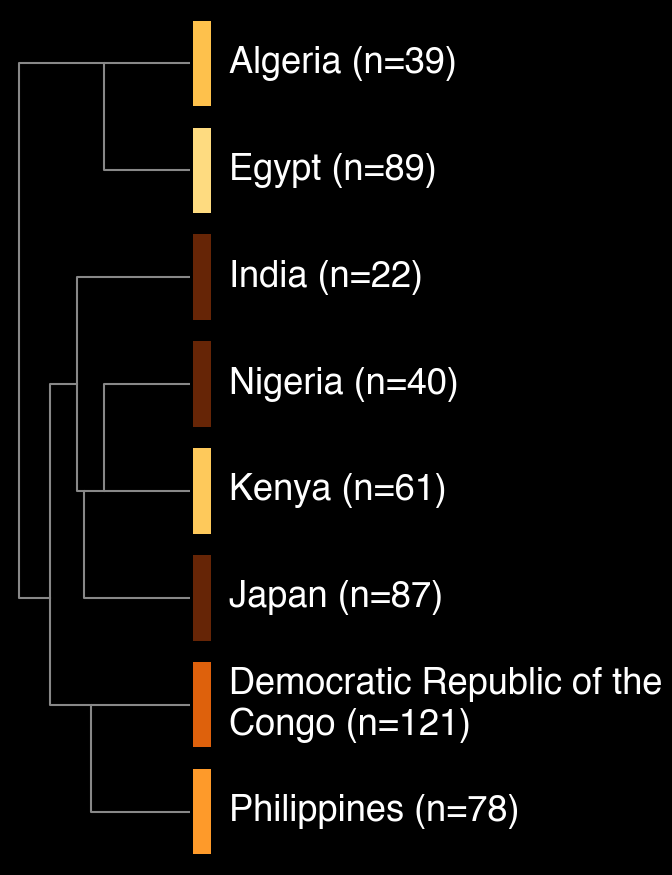

In [9]:
from himalayas.plot import plot_dendrogram_condensed

LABEL_COLOR = "white"
BACKGROUND_COLOR = "black"
FONT = "Helvetica"

cluster_dendrogram = plot_dendrogram_condensed(
    results_sig,
    term_col="term",
    cluster_col="cluster",
    weight_col="pval",
    label_mode="top_term",
    label_col="term",
    figsize=(3.0, 9.5),
    sigbar_cmap="YlOrBr",
    sigbar_width=0.06,
    sigbar_height=0.8,
    sigbar_min_logp=0.0,
    sigbar_max_logp=10.0,
    font=FONT,
    fontsize=26,
    max_words=24,
    wrap_text=True,
    wrap_width=28,
    overflow="ellipsis",
    omit_words=(),
    label_fields=("label", "n"),
    label_color=LABEL_COLOR,
    label_left_pad=0.06,
    dendrogram_color="#888888",
    dendrogram_lw=1.5,
    label_overrides={7: "Democratic Republic of the Congo"},
    background_color=BACKGROUND_COLOR,
)
cluster_dendrogram.save(
    PNG_DIR / "world_recipe_condensed_dendrogram.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.02,
)
cluster_dendrogram.show()

## Summarize Cluster Feature Usage

Inspect dominant ingredients per cluster in a compact grid summary.


Saved png/supp_fig_2/cluster_feature_usage_grid.png


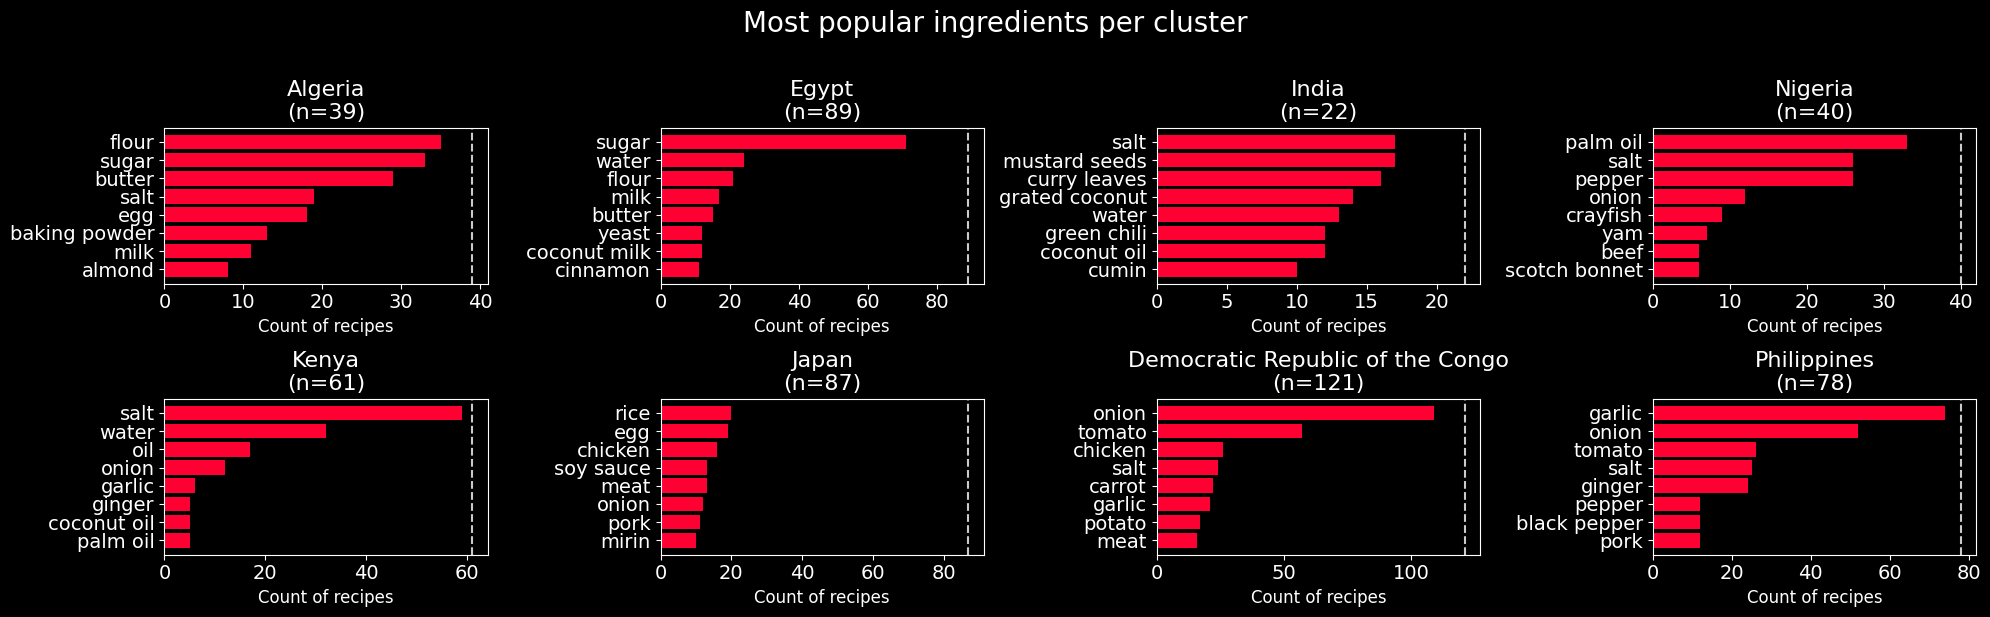

In [10]:
import math

import matplotlib.pyplot as plt


LABEL_COLOR = "white"
BACKGROUND_COLOR = "black"


def _truncate_label(label, max_chars):
    """Truncate a label to max_chars and append ellipsis when needed."""
    if max_chars is None:
        return label
    if len(label) <= max_chars:
        return label
    return label[: max_chars - 3] + "..."


def plot_cluster_feature_usage_grid(
    matrix,
    clusters,
    cluster_labels,
    cluster_ids=None,
    threshold=0.0,
    top_n=10,
    ncols=None,
    figsize_per_ax=(4, 3),
    max_label_chars=25,
    export_name=None,
):
    """Plot ingredient-usage barplots for multiple clusters in a grid."""
    # Default to the order used in cluster_labels for consistent reporting.
    if cluster_ids is None:
        cluster_ids = list(cluster_labels["cluster"])

    n = len(cluster_ids)
    if ncols is None:
        ncols = math.ceil(math.sqrt(n))
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(figsize_per_ax[0] * ncols, figsize_per_ax[1] * nrows),
        squeeze=False,
    )
    fig.patch.set_facecolor(BACKGROUND_COLOR)
    fig.subplots_adjust(
        left=0.06,
        right=0.98,
        top=0.90,
        bottom=0.08,
        wspace=0.35,
        hspace=0.45,
    )

    label_map = dict(zip(cluster_labels.cluster, cluster_labels.label))

    for ax, cid in zip(axes.flat, cluster_ids):
        ax.set_facecolor(BACKGROUND_COLOR)
        # Restrict to recipes assigned to this cluster.
        recipes = list(clusters.cluster_to_labels[cid])
        df = matrix.df.loc[recipes]
        n_items = len(recipes)
        # Convert to binary ingredient presence and count per ingredient.
        binary = (df > threshold).astype(int)
        counts = binary.sum(axis=0)
        counts = counts[counts > 0].sort_values(ascending=False)
        if counts.empty:
            ax.axis("off")
            continue

        top = counts.head(top_n)[::-1]
        labels = [_truncate_label(lbl, max_label_chars) for lbl in top.index]
        ax.barh(labels, top.values, color="#FF0033")
        # Dashed line marks cluster size (the maximum possible ingredient count).
        ax.axvline(
            n_items,
            color=LABEL_COLOR,
            linestyle="--",
            linewidth=1.5,
            alpha=0.8,
        )

        label = (
            label_map.get(cid, f"Cluster {cid}") if cid != 7 else "Democratic Republic of the Congo"
        )
        ax.set_title(f"{label}\n(n={n_items})", fontsize=16, color=LABEL_COLOR)
        ax.set_xlim(0, max(n_items, top.values.max()) * 1.05)
        for spine in ax.spines.values():
            spine.set_color(LABEL_COLOR)
        ax.tick_params(axis="x", labelsize=14, colors=LABEL_COLOR)
        ax.tick_params(axis="y", labelsize=14, colors=LABEL_COLOR)
        ax.set_xlabel("Count of recipes", fontsize=12, color=LABEL_COLOR)

    # Hide unused panels when cluster count is not a perfect grid.
    for ax in axes.flat[n:]:
        ax.axis("off")
    fig.suptitle(
        "Most popular ingredients per cluster",
        fontsize=20,
        y=1.02,
        color=LABEL_COLOR,
    )
    plt.tight_layout()
    if export_name:
        save_figure_png(export_name, fig=fig)
    plt.show()


plot_cluster_feature_usage_grid(
    matrix=results.matrix,
    clusters=results.clusters,
    cluster_labels=cluster_labels,
    top_n=8,
    threshold=0.5,
    max_label_chars=20,
    ncols=4,
    figsize_per_ax=(5, 3),
    export_name="cluster_feature_usage_grid",
)